**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear 
Program Fall 2024; Prof. V. F. de Almeida

# Constant Thermal Conductivity, Inhomogeneous Source, and Robin Boundary Conditions

**Student(s):**  Kyle Mills and Billy Manco and Donaita Anglade <br>
**Course:** Engy-4390: Nuclear Systems Design and Analysis  <br>
**Mentor and Collaborator:** Subash Sharma and Valmor de Almeida

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**21 Oct 2024**

---
## Table of Contents<a id="toc"></a>
* [Definitions](#defs)
* [Setup](#setup)
* [Test](#test)
---

## Objectives<a id="toc"></a>
+ Solve a 1-D heat conduction problem with the source and specified boundary temperatures.
+ Comparison of Test 4 to Gold Test 4

## [Problem Data](#toc)<a id="defs"></a>
Heating power density, $f(x)$, is dependent on position, thermal conductivity, $k$ is a constant:

* k(x) = 42  [$ \frac{W}{mK} $]
* f(x) = 206151 [$ \frac{W}{m^3} $]
* a = 0 [cm]
* b = 5 

and the temperature at the ends of the domain are specified as a Robin BC:
* T(a) = 20 [°C], and T(b) = 40 [°C]

## [Setup of FEM](#toc)<a id="setup"></a>

In [7]:
'''Domain'''
'''Rayleigh Ritz Method with Lagrange FE Basis Functions'''
x_min = 0      #m 
x_max = 0.05   #m

degree = 2  #Degree of the lagrange polinomials used
n_elem = 10 #Number of elements used

In [8]:
'''Domain partition'''
from pyfires import get_domain_partition
'''Parent mapping'''
from pyfires import get_parent_mapping
'''The basis functions'''
from pyfires import get_parent_basis_functions
'''Again the function for the obtaining of the basis functions'''
from pyfires import global_basis_function
'''All global basis functions'''
from pyfires import get_global_basis_functions
'''Inner product'''
from pyfires import inner_product

In [9]:
'''FEM Solution'''
'''Domain partition'''

domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[0]
phi_prime_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)[1]

## **Important Note**
With the Robin BC at both ends of the domain, the basis functions evaluated are exactly 1.0. This is not demonstrated below, as 'pyfires.py' cannot handle Robin BC. The A and B matrices can also not handle the Robin BC. 

## [Implementing Data](#toc)<a id="test"></a>

Test four constraints the system to a constant conductivity but a position dependent source term with Robin boundary condition. The goal of simulating the domain in these conditions is to create a graphical solution on how heat is transferred. 

In [13]:
'''Heat Transfer Coefficient'''
htc = 25 # W/m^2/K      # Heat Transfer Coefficient
u_ref_a = 20 # temperature at point a in degrees C
u_ref_b = 40 # temperature at point b in degrees C

In [14]:
'''Thermal conductivity'''
from pyfires import linear_func
from pyfires import plot_func

k_func = linear_func(x_min, x_max, (42.0, 42.0)) # W/mK

'''Heating Power Density'''
f_func = linear_func(x_min, x_max, (824604, 824604)) # W/m^3

view_plots = False

In [15]:
if view_plots:
    n_plot_pts = 200
    title = 'Thermal Conductivity'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'K [W/mk]'
    plot_func(k_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Heating Power Density'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'f [W/m^3]'
    plot_func(f_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [16]:
if view_plots:
    n_plot_pts = 200
    title = 'Thermal Conductivity'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'K [W/mk]'
    plot_func(lift_func, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

    title = 'Heating Power Density'
    xlabel = 'Position along the width of the channel wall [m]'
    ylabel = 'f [W/m^3]'
    plot_func(lift_func_prime, x_min, x_max, n_plot_pts, title=title, xlabel=xlabel, ylabel=ylabel)

In [17]:
'''Build FEM A matrix'''
from pyfires import build_a_mtrx_robin_bc

a_mtrx = build_a_mtrx_robin_bc(phi_list, phi_prime_list, k_func, domain_partition, x_min, x_max, n_elem, htc)

In [18]:
'''Build load vector'''
from pyfires import build_b_vec_robin_bc

b_vec = build_b_vec_robin_bc(phi_list, phi_prime_list, 
                   f_func, domain_partition, x_min, x_max, n_elem, htc, u_ref_a, u_ref_b)

### [Results](#toc)<a id = "Results"></a>

In [20]:
'''Solution'''
'''Compute optimal coefficient vector'''
import numpy as np

c_star_vec = np.linalg.solve(a_mtrx, b_vec)

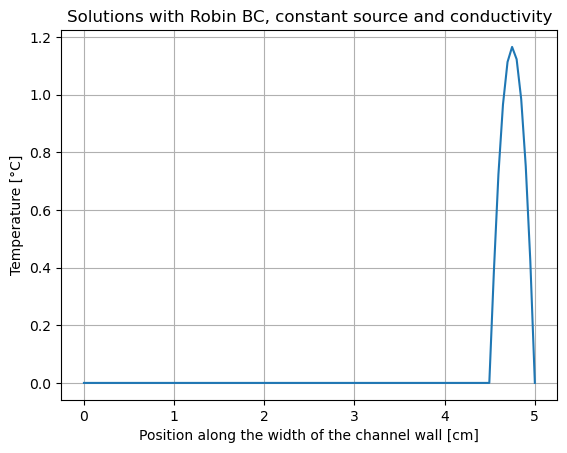

In [21]:
from pyfires import u_star_no_lift
u_star = lambda x: u_star_no_lift(x, phi_list, c_star_vec)
plot_func(u_star, x_min, x_max, 100,
          x_scale=100, 
          title='Solutions with Robin BC, constant source and conductivity', 
          xlabel='Position along the width of the channel wall [cm]',
          ylabel='Temperature [°C]')

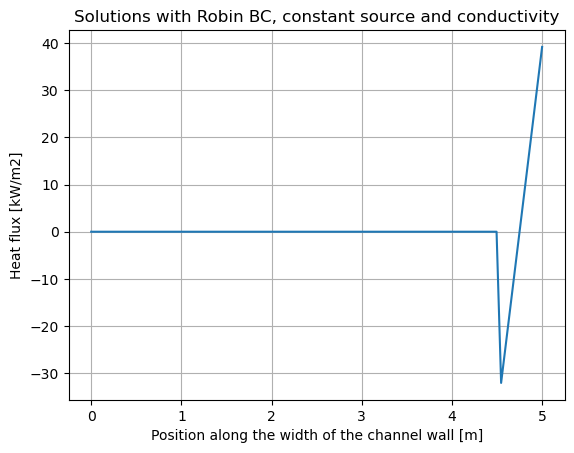

In [22]:
from pyfires import u_star_prime_no_lift
h_e = (x_max-x_min)/n_elem
q_x = lambda x: - k_func(x) * u_star_prime_no_lift(x, phi_prime_list, c_star_vec, h_e)
plot_func(q_x, x_min, x_max, 100, 
          x_scale=100, y_scale=1/1000,
          title='Solutions with Robin BC, constant source and conductivity', 
          xlabel='Position along the width of the channel wall [m]',
          ylabel='Heat flux [kW/m2]')

In [23]:
'''Normal heat flux at boundaries'''
n_x_a = -1.0
n_x_b =  1.0
print('q_n(a) = ', q_x(x_min) * n_x_a/1000, 'W/m^2')
print('q_n(b) = ', q_x(x_max) * n_x_b/1000, 'W/m^2')

q_n(a) =  [0.] W/m^2
q_n(b) =  [39.16869] W/m^2


### [Results Comparison with Gold-Data](#toc)<a id = "Comparison"></a>

In [25]:
import numpy as np
(x,u,q) = np.loadtxt('gold-data/04-test-gold.txt')
u_gold = np.column_stack((x,u))

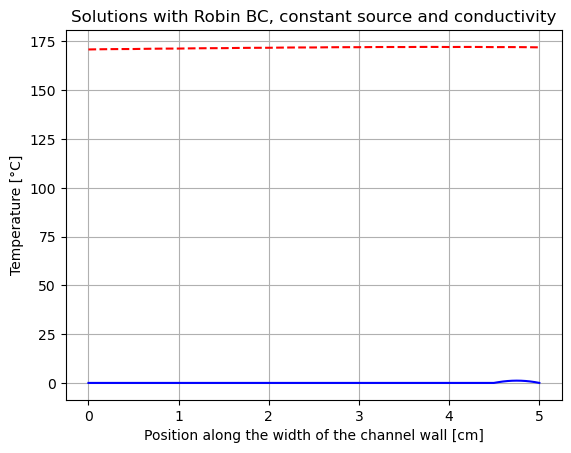

In [26]:
plot_func(u_star, x_min, x_max, 100,
          x_scale=100,
          title='Solutions with Robin BC, constant source and conductivity', 
          xlabel='Position along the width of the channel wall [cm]',
          ylabel='Temperature [°C]', gold_data=u_gold)

In [27]:
import numpy as np
(x,u,q) = np.loadtxt('gold-data/04-test-gold.txt')
q_gold = np.column_stack((x,q))

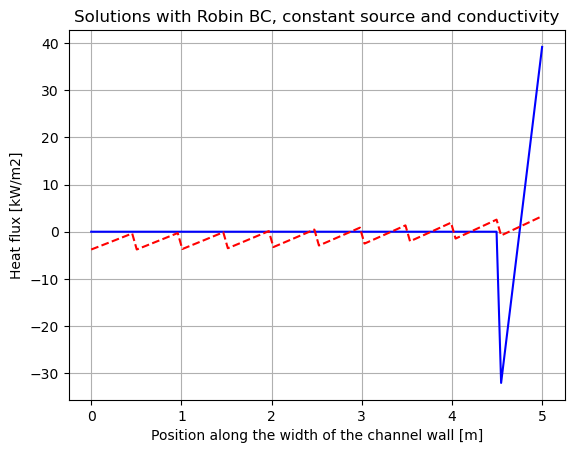

In [28]:
h_e = (x_max-x_min)/n_elem
q_x = lambda x: - k_func(x) * u_star_prime_no_lift(x, phi_prime_list, c_star_vec, h_e)
plot_func(q_x, x_min, x_max, 100, 
          x_scale=100, y_scale=1/1000,
          title='Solutions with Robin BC, constant source and conductivity', 
          xlabel='Position along the width of the channel wall [m]',
          ylabel='Heat flux [kW/m2]', gold_data = q_gold)